In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
from scipy.stats import spearmanr, kendalltau

import pickle as pkl
import numpy as np

In [3]:
sys.path.insert(1, '../../')

In [4]:
from utils.imagenet_dataset import get_dataset
from utils.image_processing import preprocess_image_drc
from models.student_models  import  student3


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [5]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

Download kay_labels.npy completed!
Download kay_labels_val.npy completed!
Download kay_images.npz completed!


In [6]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [7]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [8]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [9]:
drc_args=dict(                    preprocessing='default',rggb_mode=False,
                    return_position_info=False, offsets = None,
                    unprocess_high_res=False,enable_random_gains=False,n_steps=5,res=56,
              central_squeeze_and_pad_factor=-1)

Each stimulus is a 128 x 128 grayscale array:

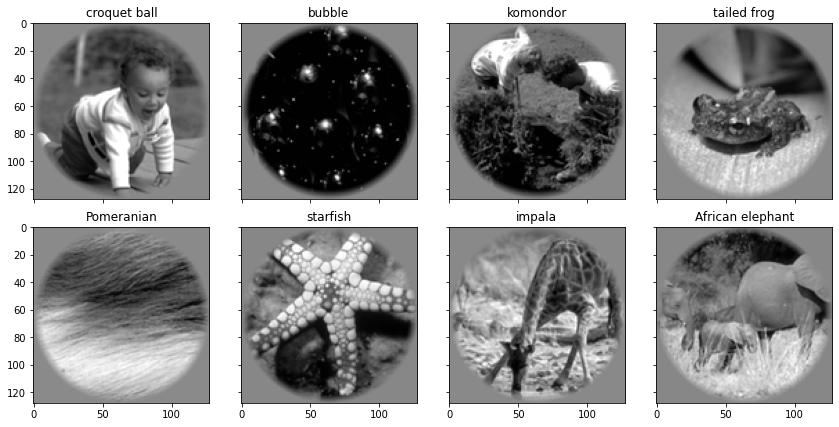

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

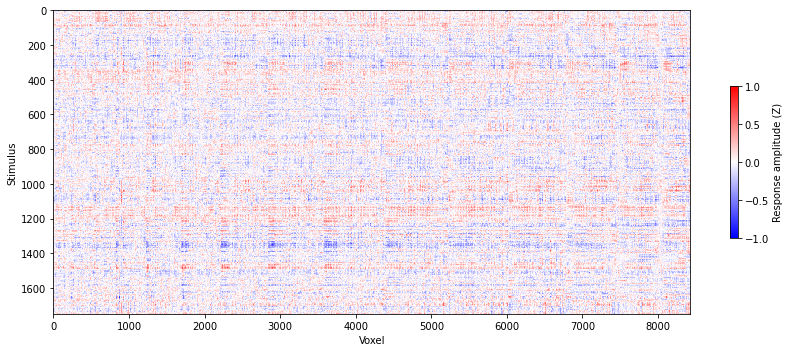

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

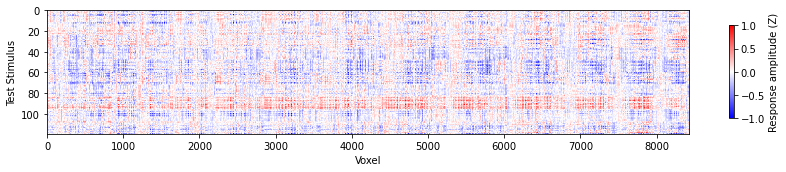

In [12]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [13]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

# tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
tf.config.experimental.set_memory_growth(gpus[0], True)
from tensorflow import keras


2023-03-22 11:28:37.906409: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1917] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GT 730, pci bus id: 0000:65:00.0, compute capability: 3.5) with core count: 2. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.


In [14]:
drc_fe_args = {'sample': 5, 'res': 56, 'activation': 'relu', 'dropout': 0.0, 
               'rnn_dropout': 0.0, 'num_features': 128, 'rnn_layer1': 32, 'rnn_layer2': 64, 
               'layer_norm': False, 'batch_norm': False, 'conv_rnn_type': 'lstm', 
               'block_size': 1, 'add_coordinates': 0, 'time_pool': 'average_pool', 'dense_interface': True,
               'loss': 'mean_squared_error', 'upsample': 0, 'pos_det': None, 'enable_inputB': False,
               'expanded_inputB': False, 'rggb_ext_type': 0, 'channels': 3, 'updwn': 1,
               'kernel_size': 3, 'custom_metrics': []}

# net = keras.applications.VGG16(input_shape=(224, 224, 3),
#                                   include_top=True,
#                                   weights='imagenet')

parameters = {}

parameters['pretrained_student_path'] = 'pretrained_models/vgg16drc_baseline/noname_j1131336_t1662126871_feature_net_ckpt'
parameters['pretrained_decoder_path'] = 'pretrained_models/vgg16drc_baseline/noname_j1131336_t1662126871_saved_models/decoder_trained_model_fix0/'

In [15]:
student = student3(**drc_fe_args)
student.summary()

(None, 5, 56, 56, 3)


2023-03-22 11:28:38.417606: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10247 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:17:00.0, compute capability: 6.1


True
average_pool
(None, 56, 56, 128)
Model: "student_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5, 56, 56, 3)]    0         
_________________________________________________________________
convLSTM10 (ConvLSTM2D)      (None, 5, 56, 56, 32)     40448     
_________________________________________________________________
convLSTM20 (ConvLSTM2D)      (None, 5, 56, 56, 64)     221440    
_________________________________________________________________
convLSTM30 (ConvLSTM2D)      (None, 5, 56, 56, 128)    885248    
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 56, 56, 128)    147584    
_________________________________________________________________
average_pooling3d (AveragePo (None, 1, 56, 56, 128)    0         
_________________________________________________________________
tf.compat.v1.squeez

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [16]:
load_status1 = student.load_weights(parameters['pretrained_student_path'])
# load_status2 = decoder.load_weights(parameters['pretrained_decoder_path'])
decoder2 = keras.models.load_model(parameters['pretrained_decoder_path'])

In [17]:
def bias_and_expand(x):
    x = x-x.min()
    x = x[...,np.newaxis]
    x = np.concatenate([x,x,x],axis=3)
    return x

def preprocess_kay_for_resnet50(x):
    x = bias_and_expand(x)
    x=keras.layers.Resizing(224,224,interpolation='bilinear',
    crop_to_aspect_ratio=False,)(x).numpy()
    x = keras.applications.resnet50.preprocess_input(256*x)
    return x


def preprocess_kay_for_vgg16(x,imresize=[224,224],size=[224,224]):
    x = bias_and_expand(x)
    neutral_color = x[0,0,0,0] #pixel from the image surrounding
    x=keras.layers.Resizing(*imresize,interpolation='bilinear',
    crop_to_aspect_ratio=False,)(x).numpy()
    padding = np.ones([x.shape[0],size[0],size[1],3])*neutral_color
    start = [ (a-b)//2 for a,b in zip(size,imresize)]
    end = [ (a-b)//2+b for a,b in zip(size,imresize)]
    padding[:,start[0]:end[0],start[1]:end[1]] = x
    x = padding
    x = keras.applications.vgg16.preprocess_input(256*x)
    return x


def preprocess_grayscale(x,imresize=[224,224],size=[224,224]):
    x = bias_and_expand(x)
    neutral_color = x[0,0,0,0] #pixel from the image surrounding
    x=keras.layers.Resizing(*imresize,interpolation='bilinear',
    crop_to_aspect_ratio=False,)(x).numpy()
    padding = np.ones([x.shape[0],size[0],size[1],3])*neutral_color
    start = [ (a-b)//2 for a,b in zip(size,imresize)]
    end = [ (a-b)//2+b for a,b in zip(size,imresize)]
    padding[:,start[0]:end[0],start[1]:end[1]] = x
    x = padding
    return x


def preprocess_for_drc_image(x,**kwargs):
    low_res_frames, _ = preprocess_image_drc(x, x.shape[-2], kwargs['res'], is_training=False,teacher_mode=False,**kwargs)
    return low_res_frames


def preprocess_for_drc_batch(x, **kwargs):
    s = np.shape(x)
    n_steps = kwargs['n_steps']
    res = kwargs['res']
    xout = np.zeros([s[0],n_steps,res,res,s[-1]])
    for ii,this_image in enumerate(x):
        xout[ii] = preprocess_for_drc_image(tf.convert_to_tensor(this_image,dtype=tf.float32),**kwargs)
    return xout
    



In [18]:
input0 = keras.layers.Input(shape=(5, 56, 56, 3))

x = student(input0)
x = decoder2(x)
net = keras.models.Model(inputs=[input0], outputs=x, name='frontend')

In [19]:
# sz_list = [56,96,128,192,224]
sz_list = [224]
amp_list = [0,1,2,4,8,12,18,27]
dat['grayscale_sz'] = {}
for sz in sz_list:
#     low_res_frames, high_res_image = preprocess_image_drc(image, high_res, low_res, is_training=is_training,teacher_mode=True,**kwargs)

    dat['grayscale_sz'][sz] = preprocess_grayscale(dat["stimuli"],imresize=[sz,sz])

2023-03-22 11:28:40.491864: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1053696000 exceeds 10% of free system memory.


In [20]:
# batch_size = 256
# data = dat["resnet"]
#layer_to_eval= net.layers[2]
def preds_from_batches(layer_to_eval,data,batch_size = 64, sample_size=-1,time_mode='mean',drc_args={} ):
    data_len = data.shape[0]
    samples_set_flag=False
       
    for batch in range(data_len//batch_size):
        start = batch*batch_size
        end = min((batch+1)*batch_size,data_len)
        result = layer_to_eval(preprocess_for_drc_batch(data[start:end],**drc_args))
        result = result.numpy()
        if np.ndim(result)==5:
            if time_mode == 'mean':
                result = result.mean(axis=1)
            else:
                error
        result = result.reshape([end-start,-1])
        if not samples_set_flag and sample_size > 0:
            samples = np.random.choice(result.shape[-1],sample_size)
            samples_set_flag = True
        if batch==0:
            ll_out = np.zeros([data_len,result.shape[-1]]) if sample_size == -1 else np.zeros([data_len,sample_size])
        ll_out[start:end,:] = result if sample_size == -1 else result[:,samples]
    return ll_out

In [21]:
RDM_net_sz={}
for sz in sz_list:
    RDM_net_sz[sz]={amp:{} for amp in amp_list} 
for ll,layer in enumerate(student.layers + decoder2.layers):
    drc_part = 'fe' if ll<len(student.layers) else 'be'
    print(ll, layer.name)
    if drc_part == 'fe':
        feature_extractor = keras.Model(
           inputs=student.inputs,
           outputs=layer.output,
            )
    if drc_part == 'be':
        submodel = keras.Model(inputs=decoder2.inputs, outputs = layer.output)
        input0 = keras.layers.Input(shape=(5, 56, 56, 3))
        x = student(input0)
        x = submodel(x)
        net = keras.models.Model(inputs=[input0], outputs=x, name='frontend')
        feature_extractor = keras.Model(
        inputs=input0,
        outputs=x,
        )
        
    for sz in sz_list:
        for amp in amp_list:
            drc_args['amp']=amp
            activity = preds_from_batches(feature_extractor,dat["grayscale_sz"][sz],
                                          batch_size=64,
                                          sample_size=3000,
                                          time_mode='mean',
                                          drc_args=drc_args)
            RDM_net_sz[sz][amp][ll] = 1-np.corrcoef(activity)
    del feature_extractor

0 input_1


/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


1 convLSTM10


2023-03-22 11:30:55.868216: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8300


2 convLSTM20
3 convLSTM30
4 time_distributed
5 average_pooling3d
6 tf.compat.v1.squeeze
7 input_top
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool
20 flatten
21 fc1
22 fc2
23 predictions


In [22]:
def substract_chunk_mean(data,chunk_size):
    #substracts mean from each chunk of columns
    #we do that to filter out correlations thatis responsible to block wise structure in the original data and which is possibly due to 
    #division into recording sessions
    if data.shape[0]%chunk_size != 0:
        error
    else:
        new_data = np.zeros(data.shape) #to avoid pass by pointer mess
        for dd in range(data.shape[0]//chunk_size):
            start = dd*chunk_size
            end = start + chunk_size
            datachunk = data[start:end]
            datachunk -= datachunk.mean(axis=0)[np.newaxis,:]
            new_data[start:end] = datachunk
        return new_data

In [23]:
RDM_fmri_filter70 = {}
for roi in set(dat["roi"]):
    RDM_fmri_filter70[roi] = 1-np.corrcoef(substract_chunk_mean(dat["responses"][:,dat["roi"]==roi],70))

In [24]:
RDM_fmri = {}
for roi in set(dat["roi"]):
    RDM_fmri[roi] = 1-np.corrcoef(dat["responses"][:,dat["roi"]==roi])

In [25]:
from scipy.stats import spearmanr, kendalltau

In [26]:
def corr_list_extractor(RDM_net,RDM_fmri,corr_fun=spearmanr):
    corr_list = []
    for brain_area in range(1,8):
        for cnn_layer in range(len(RDM_net)):
            sz=RDM_net[cnn_layer].shape[0]
            mask = np.triu(np.ones([sz,sz],dtype=np.bool),1)
            corr, pval = corr_fun(np.nan_to_num(RDM_net[cnn_layer][mask]),RDM_fmri[brain_area][mask])
            corr_list.append(corr)
    return corr_list

In [27]:
corr_mat = {}
for sz in sz_list:
    corr_mat[sz]={}
    for amp in amp_list:
        print(sz,amp)
        corr_list = corr_list_extractor(RDM_net_sz[sz][amp],RDM_fmri)
        corr_mat[sz][amp] = np.array((corr_list)).reshape([7,-1])


224 0
224 1
224 2
224 4
224 8
224 12
224 18
224 27


In [28]:
corr_mat70 = {}
for sz in sz_list:
    corr_mat70[sz]={}
    for amp in amp_list:
        print(sz,amp)
        corr_list = corr_list_extractor(RDM_net_sz[sz][amp],RDM_fmri_filter70)
        corr_mat70[sz][amp] = np.array((corr_list)).reshape([7,-1])


224 0
224 1
224 2
224 4
224 8
224 12
224 18
224 27


In [29]:
amp_list

[0, 1, 2, 4, 8, 12, 18, 27]

In [30]:
corr_mat70[sz]

{0: array([[0.01764033, 0.0255786 , 0.02907247, 0.04607339, 0.08382464,
         0.08196791, 0.08166901, 0.08012169, 0.0649312 , 0.05788386,
         0.04477849, 0.06203268, 0.05560639, 0.05423676, 0.04455839,
         0.05238366, 0.04933387, 0.04928913, 0.04216855, 0.05271687,
         0.04481233, 0.04033176, 0.03764731, 0.01765973],
        [0.01539611, 0.02279904, 0.02318233, 0.04089031, 0.07306855,
         0.07151586, 0.07099176, 0.07022864, 0.05802495, 0.0513421 ,
         0.04055467, 0.05746354, 0.05151572, 0.05014658, 0.04065217,
         0.04874823, 0.04643138, 0.04635258, 0.03990091, 0.04970013,
         0.0424431 , 0.03844233, 0.03577548, 0.01669816],
        [0.0067654 , 0.00997179, 0.01030739, 0.01779869, 0.03480968,
         0.03400443, 0.03338494, 0.03320026, 0.03022852, 0.02720066,
         0.02152901, 0.03128558, 0.02779615, 0.02646785, 0.02347464,
         0.02675346, 0.02733256, 0.02909645, 0.02608193, 0.03423475,
         0.02866849, 0.02854639, 0.02667385, 0.014658

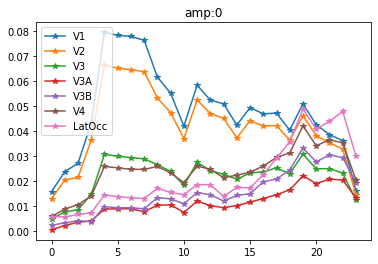

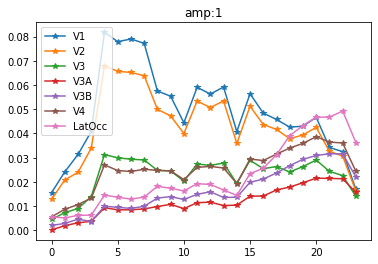

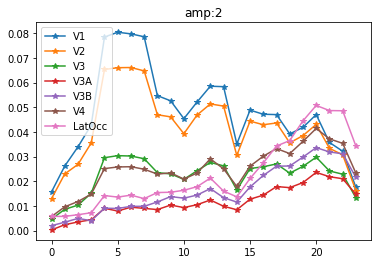

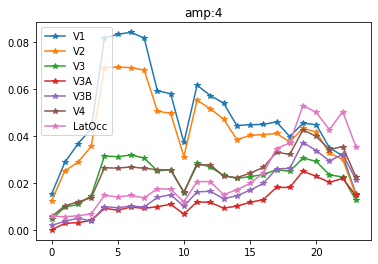

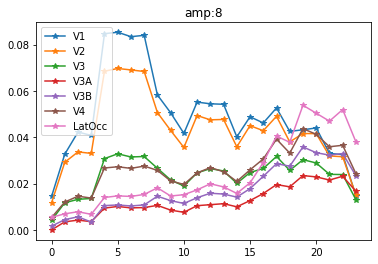

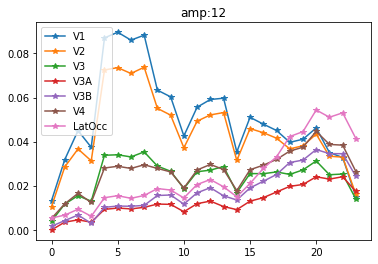

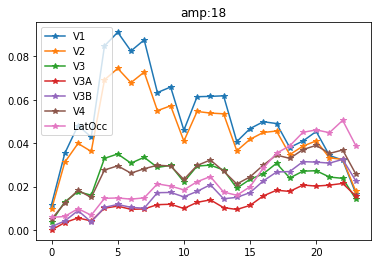

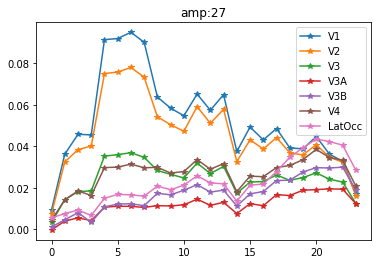

In [31]:
for amp in amp_list:
    plt.figure()
    plt.plot(corr_mat[sz][amp].transpose(),'*-')
    plt.title('amp:'+str(amp))
    plt.legend(dat["roi_names"][1:])
#     plt.xlim([-1,22])

In [32]:
corr_mat[sz]

{0: array([[0.01564705, 0.02371902, 0.02703979, 0.04318895, 0.07958478,
         0.07831936, 0.0779192 , 0.07634007, 0.06161128, 0.05510768,
         0.04196924, 0.05832705, 0.05239119, 0.05086335, 0.04238539,
         0.04936013, 0.04688192, 0.04714833, 0.04036779, 0.0508684 ,
         0.04254132, 0.03852365, 0.03614487, 0.01610194],
        [0.01280469, 0.02035314, 0.02138762, 0.03641273, 0.06641991,
         0.06513867, 0.06459113, 0.06377794, 0.05319626, 0.0473444 ,
         0.03693992, 0.05241678, 0.04697152, 0.04509048, 0.03727483,
         0.04409415, 0.04199161, 0.04211724, 0.03635188, 0.04608752,
         0.03817415, 0.03530552, 0.03273374, 0.01453117],
        [0.00471388, 0.007591  , 0.00840204, 0.01461106, 0.03059934,
         0.0298996 , 0.02931272, 0.028843  , 0.02649048, 0.02382646,
         0.01818499, 0.02743539, 0.02410147, 0.02264722, 0.02065221,
         0.02315903, 0.02359326, 0.02522856, 0.02284317, 0.03073939,
         0.02481556, 0.02492214, 0.02310835, 0.012376

In [33]:
corr_mat[224].max()

AttributeError: 'dict' object has no attribute 'max'

In [ ]:
for amp in amp_list:
    plt.figure()
    plt.plot(corr_mat70[sz][amp].transpose(),'*-')
    plt.title('amp:'+str(amp))
    plt.legend(dat["roi_names"][1:])
    plt.xlim([-1,22])

In [ ]:
# import pickle as pkl

# with open('VGG16_RDM_corrmapDRC_Net3amp.pkl','wb') as f:
#     pkl.dump([RDM_net_sz,corr_mat,corr_mat70],f)

In [ ]:


# with open('VGG16_corrmapDRC_Net3amp.pkl','wb') as f:
#     pkl.dump([corr_mat,corr_mat70],f)